[link text](https:// [link text](https://))# Mounting Goolge drive.

First add the data to your google drive using the following link:

https://drive.google.com/drive/folders/1I0MTQwn2HXquEiXdtntgRggqw6xJr47b?usp=sharing

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installing required packages

GPU and available memory check

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=da8635e62e777a0be0b7f0cf88021dfb62486740bfbe076e5477cc981597ac55
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 26.4 GB  |     Proc size: 112.5 MB
GPU RAM Free: 16130MB | Used: 0MB | Util   0% | Total     16130MB


Transformers for general purpose NLP models

Unidecode for ASCII translation of Unicode text.

In [ ]:
!pip3 install transformers
!pip3 install unidecode

     |████████████████████████████████| 1.3MB 14.2MB/s 
     |████████████████████████████████| 2.9MB 47.0MB/s 
     |████████████████████████████████| 890kB 58.7MB/s 
     |████████████████████████████████| 1.1MB 47.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=138f5d45bd773e513ab735f53de0412092ffd53f54b5eb844dc50ef46d2fcf78
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 245kB 12.4MB/s 


# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
from os import listdir
from os.path import join
import unidecode
import re
import logging
from tqdm.notebook import tnrange
import glob
import json

#For ploting results
import matplotlib.pyplot as plt

# DL Libraries
from transformers import BertModel, AdamW, BertTokenizer, BertConfig, RobertaTokenizer, RobertaModel
from keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, f1_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print("device: {} n_gpu: {}".format(device, n_gpu)) 

device: cuda n_gpu: 1


In [ ]:
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)
print(logger)

<Logger __main__ (INFO)>


#Data Processing

Function to tokenize input dataframe (Query, Sentence, Label) and return tensorDatset with corresponding input_id, attention_masks and labels as a PyTorch dataloader. 

In [ ]:
def create_dataloader(tokenizer, df):
    input_ids= list()
    attention_masks= list()

    print("Shape: {}".format(df.shape))

    special_sentences_1 = [sentence for i, sentence in enumerate(df.question)]
    special_sentences_2 = [" [SEP] " + str(sentence) for i, sentence in enumerate(df.sentence)]
    special_sentences = [i + j for i, j in zip(special_sentences_1, special_sentences_2)]

    for sentence in special_sentences:
      encoded_text = tokenizer.encode_plus(sentence, max_length=512, add_special_tokens=True, return_token_type_ids=False, 
                                       padding='max_length', return_attention_mask=True, truncation=True)
      input_ids.append(encoded_text['input_ids'])
      attention_masks.append(encoded_text['attention_mask'])

    inputs = torch.tensor(input_ids).to(device)
    masks = torch.tensor(attention_masks).to(device)
    gold_labels = torch.tensor(df.sia_score.tolist()).to(device)
  
    data = TensorDataset(inputs, masks, gold_labels)
    sampler = RandomSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=4)

    return dataloader

To load the dataset from google drive.

**!!! Please change the directory accordingly !!!**

Performing the train-test split after shuffling the dataset.

In [ ]:
load_data= '/content/drive/My Drive/Sahit/work/project_nlp/data'

data_df= pd.read_csv(join(load_data,'data60k.csv'))
data_df= shuffle(data_df)

train_df, test_df= train_test_split(data_df, test_size=0.2)

Loading pretrained 'roberta-base' tokenizer and creating dataloader for train & test dataframes.

In [ ]:
#Dataloaders
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_dataloader= create_dataloader(tokenizer, train_df)
test_dataloader= create_dataloader(tokenizer, test_df)

11/20/2020 07:27:09 - INFO - filelock -   Lock 140109902941264 acquired on /root/.cache/torch/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock


11/20/2020 07:27:10 - INFO - filelock -   Lock 140109902941264 released on /root/.cache/torch/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock


11/20/2020 07:27:11 - INFO - filelock -   Lock 140112349613976 acquired on /root/.cache/torch/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


11/20/2020 07:27:11 - INFO - filelock -   Lock 140112349613976 released on /root/.cache/torch/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock



Shape: (49672, 4)
Shape: (12419, 4)


# Model

Model: 'roberta-base' with a Linear layer on top to generate SIA scores.

In [ ]:
#Class for Regression
class Regressor(nn.Module):

  def __init__(self):
    super(Regressor, self).__init__()
    self.bert = RobertaModel.from_pretrained('roberta-base')
    self.out = nn.Linear(self.bert.config.hidden_size, 1)

  def forward(self, input_ids, attention_mask):
    output, pooler_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    score= self.out(pooler_out)
    return score
    

Model Initialization with:

* 10 epochs

* 'AdamW' optimizer

* Mean Squared Error (MSE) Loss function

In [ ]:
#Model Intialization

epochs = 10

#Load Model
model= Regressor()
model.to(device)

# Prepare optimizer
optimizer = AdamW(model.parameters(),lr=2e-5)

#Loss Function
mse_loss= nn.MSELoss().to(device)

11/20/2020 07:28:01 - INFO - filelock -   Lock 140109532988920 acquired on /root/.cache/torch/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock


11/20/2020 07:28:01 - INFO - filelock -   Lock 140109532988920 released on /root/.cache/torch/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock


11/20/2020 07:28:02 - INFO - filelock -   Lock 140109582622000 acquired on /root/.cache/torch/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock


11/20/2020 07:28:08 - INFO - filelock -   Lock 140109582622000 released on /root/.cache/torch/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock


#Training and Evaluation

Creating output directory:

model path: '/content/drive/My Drive/project_nlp/sia_experiment/model1'

result path: '/content/drive/My Drive/project_nlp/sia_experiment/results1'

In [ ]:
output_dir= '/content/drive/My Drive/project_nlp/sia_experiment/modelMSMARCO'
output_result= '/content/drive/My Drive/project_nlp/sia_experiment/resultsMSMARCO'

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

if not os.path.exists(output_result):
  os.makedirs(output_result)

Model training followed by model evaluation

In [ ]:
for iteration in tnrange(epochs, desc='Epochs'):
  model.train()
  logger.info("Running for iteration: {}".format(iteration+1))

  training_loss, training_steps = 0,0
  true_labels, predicted_labels = list(), list()
  
  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    ip_ids, masks, gold_labels= batch
    score = model(ip_ids, attention_mask=masks)
    score = score.squeeze(1)
    loss= mse_loss(score, gold_labels.float())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    training_loss+=loss.item()
    training_steps+=1
    if (step+1)%10000 == 0:
      print(step+1)

    true_labels.extend(gold_labels.cpu().numpy())
    predicted_labels.extend(score.detach().cpu().numpy())
  
  training_loss_for_epoch= training_loss/training_steps
  pcc= pearsonr(true_labels, predicted_labels)
  rmse= mean_squared_error(true_labels, predicted_labels, squared=False)
  
  result = {'loss': training_loss_for_epoch, 'PCC': pcc[0], 'RMSE':rmse}
  print(result)

  model_to_save = model.bert.module if hasattr(model.bert, 'module') else model.bert
  model_to_save.save_pretrained(output_dir)

  torch.save(model.out.state_dict(), join(output_dir, 'model_state.bin'))

  #Testing
  print("Running evaluation for epoch: {}".format(iteration+1))

  true_labels, predicted_labels= list(), list()
  model.eval()
  with torch.no_grad():
    for step, batch in enumerate(test_dataloader):
      batch = tuple(t.to(device) for t in batch)
      ip_ids, masks, gold_labels= batch
      score = model(ip_ids, attention_mask=masks)
      score = score.squeeze(1)

      true_labels.extend(gold_labels.cpu().numpy())
      predicted_labels.extend(score.detach().cpu().numpy())
  
  pcc= pearsonr(true_labels, predicted_labels)
  rmse= mean_squared_error(true_labels, predicted_labels, squared=False)
  test_report= {'PCC': pcc[0], 'RMSE':str(rmse)}
  print(test_report)

  with open(join(output_result, 'result_'+str(iteration+1)+'.json'), 'w') as fp:
    json.dump(test_report, fp)


11/20/2020 07:28:12 - INFO - __main__ -   Running for iteration: 1


10000
{'loss': 0.36069470434314616, 'PCC': 0.7220299296690421, 'RMSE': 0.60057867}
Running evaluation for epoch: 1
{'PCC': 0.813001740702419, 'RMSE': '0.52376467'}


11/20/2020 08:01:56 - INFO - __main__ -   Running for iteration: 2


10000
{'loss': 0.228705441012905, 'PCC': 0.8342812108816875, 'RMSE': 0.4782316}
Running evaluation for epoch: 2
{'PCC': 0.8400303430983965, 'RMSE': '0.50446314'}


11/20/2020 08:35:41 - INFO - __main__ -   Running for iteration: 3


10000
{'loss': 0.16595294648451905, 'PCC': 0.8828384289150286, 'RMSE': 0.40737322}
Running evaluation for epoch: 3
{'PCC': 0.8495938339980833, 'RMSE': '0.473137'}


11/20/2020 09:09:34 - INFO - __main__ -   Running for iteration: 4


10000
{'loss': 0.126398724073438, 'PCC': 0.9121236280137388, 'RMSE': 0.35552597}
Running evaluation for epoch: 4
{'PCC': 0.8532544609667987, 'RMSE': '0.4688463'}


11/20/2020 09:43:20 - INFO - __main__ -   Running for iteration: 5


10000
{'loss': 0.09701180297040386, 'PCC': 0.9332908207225082, 'RMSE': 0.31146717}
Running evaluation for epoch: 5
{'PCC': 0.8639822209684618, 'RMSE': '0.44421396'}


11/20/2020 10:17:06 - INFO - __main__ -   Running for iteration: 6


10000
{'loss': 0.07889804219177331, 'PCC': 0.9461022702721584, 'RMSE': 0.28088796}
Running evaluation for epoch: 6
{'PCC': 0.8667693258926773, 'RMSE': '0.45741135'}


11/20/2020 10:50:59 - INFO - __main__ -   Running for iteration: 7


10000
{'loss': 0.06676833811231021, 'PCC': 0.9545862121977449, 'RMSE': 0.2583957}
Running evaluation for epoch: 7


11/20/2020 11:24:49 - INFO - __main__ -   Running for iteration: 8


{'PCC': 0.8697604250129233, 'RMSE': '0.45364785'}
10000
{'loss': 0.05772004318493833, 'PCC': 0.9608661136420755, 'RMSE': 0.24024995}
Running evaluation for epoch: 8


11/20/2020 11:58:33 - INFO - __main__ -   Running for iteration: 9


{'PCC': 0.8716596604736326, 'RMSE': '0.4368069'}
10000
{'loss': 0.050228939942770445, 'PCC': 0.966033803764081, 'RMSE': 0.22411814}
Running evaluation for epoch: 9


11/20/2020 12:32:20 - INFO - __main__ -   Running for iteration: 10


{'PCC': 0.8728848541296215, 'RMSE': '0.43644488'}
10000
{'loss': 0.04544604791727937, 'PCC': 0.9693194042433445, 'RMSE': 0.2131808}
Running evaluation for epoch: 10
{'PCC': 0.8672140955712699, 'RMSE': '0.44383955'}



In [ ]:
torch.save(model, '/content/drive/My Drive/project_nlp/sia_experiment/modelMSMARCO/pytorch_modelTrained')

# Visualizing the results

In [ ]:
filepaths= glob.glob(join(output_result,'*.json'))

pcc, rmse= list(), list()

for path in filepaths:
  print(path)
  f = open(path,'r') 
  data = json.load(f)
  pcc.append(data['PCC'])  
  rmse.append(float(data['RMSE']))

/content/drive/My Drive/project_nlp/sia_experiment/resultsMSMARCO/result_2.json
/content/drive/My Drive/project_nlp/sia_experiment/resultsMSMARCO/result_3.json
/content/drive/My Drive/project_nlp/sia_experiment/resultsMSMARCO/result_4.json
/content/drive/My Drive/project_nlp/sia_experiment/resultsMSMARCO/result_5.json
/content/drive/My Drive/project_nlp/sia_experiment/resultsMSMARCO/result_6.json
/content/drive/My Drive/project_nlp/sia_experiment/resultsMSMARCO/result_1.json
/content/drive/My Drive/project_nlp/sia_experiment/resultsMSMARCO/result_7.json
/content/drive/My Drive/project_nlp/sia_experiment/resultsMSMARCO/result_8.json
/content/drive/My Drive/project_nlp/sia_experiment/resultsMSMARCO/result_9.json
/content/drive/My Drive/project_nlp/sia_experiment/resultsMSMARCO/result_10.json


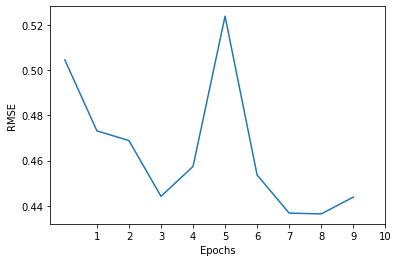

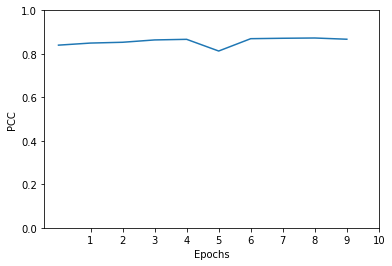

In [ ]:
#plot rmse
plt.plot(rmse)
plt.ylabel('RMSE')
plt.xticks(range(1, 11))
plt.xlabel('Epochs')
plt.savefig(join(output_result, 'rmse.png'))
plt.show()

#plot
plt.plot(pcc)
plt.ylabel('PCC')
plt.xticks(range(1, 11))
plt.ylim(0, 1)
plt.xlabel('Epochs')
plt.savefig(join(output_result, 'pcc.png'))
plt.show() 